In [143]:
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler # normalization and standardization
from xgboost import XGBClassifier

from sklearn.svm import SVC, SVR, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from skimage.feature import local_binary_pattern, hog


#### preprocess image:
    gaussian blurring
    adaptive thresholding
    
#### training model:
SVM\
KNN\
LR\
Naive Bayes\
Random Forest\
AdaBoost

Major Voting

    

# Functions

In [133]:
# class LocalBinaryPatterns:
# 	def __init__(self, numPoints=24, radius=3):
# 		# store the number of points and radius
# 		self.numPoints = numPoints
# 		self.radius = radius
# 	def describe(self, image, eps=1e-7):
# 		# compute the Local Binary Pattern representation
# 		# of the image, and then use the LBP representation
# 		# to build the histogram of patterns
# 		lbp = local_binary_pattern(image, self.numPoints,
# 			self.radius, method="uniform")
# 		(hist, _) = np.histogram(lbp.ravel(),
# 			bins=np.arange(0, self.numPoints + 3),
# 			range=(0, self.numPoints + 2))
# 		# normalize the histogram
# 		hist = hist.astype("float")
# 		hist /= (hist.sum() + eps)
# 		# return the histogram of Local Binary Patterns
# 		return hist

In [3]:
def evaluate(predict, label_set):
    if len(predict) != len(label_set):
        raise ValueError("Unequal length!")
    else:
        hit = 0
        for i, prediction in enumerate(predict):
            if prediction == label_set[i]:
                hit += 1
        print("Accuracy: %f %%" %(100*hit / len(predict)))

In [137]:
def display_img(img, title = "image"):    
    plt.imshow(img), plt.title(title)
    plt.xticks([]), plt.yticks([])
    plt.show()

In [117]:
def preprocessImg(img, new_width=80, new_height=60):
    new_dim = (new_width, new_height)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # cv2 stores bgr, change to rgb (to display for human eye)
    img = cv2.resize(img, new_dim, interpolation=cv2.INTER_LINEAR) # resize image
    img = img[2:-2][:] # crop image on four sides
#     img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) # apply grey scale
#     img = cv2.GaussianBlur(img, (5, 5), 0) # apply Gausian blur
#     img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,11,2) # apply adaptive thresholding
#     img = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,11,2)
#     display_img(img)
#     desc = LocalBinaryPatterns(24, 8) # perform LBP on image
#     hist = desc.describe(img)
    return img

In [141]:
# plot distribution of data
def plot_bar(y, loc='left', relative=True):
    width = 0.35
    if loc == 'left':
        n = -0.5
    elif loc == 'right':
        n = 0.5
 
    # calculate counts per type and sort, to ensure their order
    unique, counts = np.unique(y, return_counts=True)
    sorted_index = np.argsort(unique)
    unique = unique[sorted_index]
 
    if relative:
        # plot as a percentage
        counts = 100*counts[sorted_index]/len(y)
        ylabel_text = '% count'
    else:
        # plot counts
        counts = counts[sorted_index]
        ylabel_text = 'count'
 
    xtemp = np.arange(len(unique))
 
    plt.bar(xtemp + n*width, counts, align='center', alpha=.7, width=width)
    plt.xticks(xtemp, unique)
    plt.xlabel('class')
    plt.ylabel(ylabel_text)


In [77]:
def convert_pred_labels(predict):  # convert characters to numbers
    converted_predict = []
    for i, char in enumerate(predict):
        if char == 'A': converted_predict.append(0)
        elif char == 'B': converted_predict.append(1)
        elif char == 'C': converted_predict.append(2)
        else:
            raise ValueError("Unknown classification: %s" %(char))
    return converted_predict

In [78]:
# read and vote on predictions of every model's prediction
def majority_voting(*model_predictions):
    model_predictions = np.asarray(model_predictions)
    for i in range(len(model_predictions)):
        model_predictions[i] = convert_pred_labels(model_predictions[i])
    model_predictions = np.transpose(np.asarray(model_predictions, dtype=np.int))
    voting_results = []
    for data in model_predictions:
        major_label = np.argmax(np.bincount(data))
        if major_label == 0: voting_results.append('A')
        elif major_label == 1: voting_results.append('B')
        elif major_label == 2: voting_results.append('C')
        else: raise ValueError("Unknown classification: " + str(major_label))
    return voting_results

# Read Data

In [9]:
train_files = []
# read data labels
train_files = pd.read_csv("./data/train.csv", usecols=[0], delimiter=',', squeeze=True).tolist()
train_label_load = pd.read_csv("./data/train.csv", usecols=[1], delimiter=',', squeeze=True)
train_label_load = train_label_load.tolist()
# train_label_load = train_label_load[:2500].tolist()

# take first 300
# total of 5600 data in train folder

In [10]:
train_dataset = []
test_dataset = []
test_image_filenames = []

# # read train image
path = './data/Train/'
files = os.listdir(path)

# for file in train_files[:2500]: # get first 300 images
for file in train_files:
    p = path + file
    img = cv2.imread(p)
    train_dataset.append(preprocessImg(img))
#     print(file)

    
# # read test image, store filename and data in two lists respectively
path = './data/Test/'
files = os.listdir(path)

for file in files:
    p = path + file
    img = cv2.imread(p)
    test_image_filenames.append(file)
    test_dataset.append(preprocessImg(img))
#     print(file)



# Flatten Image to 1d Array

In [13]:
for index, image in enumerate(train_dataset):
    img_vector = image.flatten(order='C') 
    train_dataset[index] = img_vector
    
for index, image in enumerate(test_dataset):
    img_vector = image.flatten(order='C')
    test_dataset[index] = img_vector

# Train Val Split

In [15]:
X_train, X_val, y_train, y_val = train_test_split(
                                    train_dataset, train_label_load,
                                    test_size = 0.2, shuffle=True)

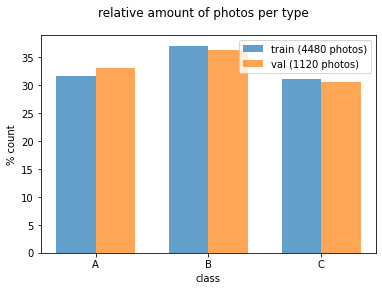

In [16]:
# plot train val distribution
plt.suptitle('relative amount of photos per type')
plot_bar(y_train, loc='left')
plot_bar(y_val, loc='right')
plt.legend([
    'train ({0} photos)'.format(len(y_train)),
    'val ({0} photos)'.format(len(y_val))
]);

# Normalize Data

In [97]:
# use StandardScalar later

# normalize train data
# normalizer = MinMaxScaler()
normalizer = StandardScaler()
X_train = normalizer.fit_transform(X_train)

# normalize val and test data "with train scaling"
X_val = normalizer.transform(X_val)
test_dataset = normalizer.transform(test_dataset)

# Reduce Dimensions (PCA)

In [18]:
# do pca on training set
pca = PCA(n_components=0.95)
pca.fit(X_train)
X_train_reduced = pca.transform(X_train)

# do on val and test set
X_val_reduced = pca.transform(X_val)
test_data_reduced = pca.transform(test_dataset)

# SVM

In [96]:
svm_classifier = SVC(kernel="linear")
svm_classifier.fit(X_train_reduced, y_train)

svm_val_predict = svm_classifier.predict(X_val_reduced)
evaluate(svm_val_predict, y_val)
# predict test
# test_predict = svm_classifier.predict(test_data_reduced).tolist()


Accuracy: 54.642857 %


In [89]:
svm_test_predict = svm_classifier.predict(test_data_reduced).tolist()

# K Nearest Neighbors

In [44]:
knn_classifier = KNeighborsClassifier(n_neighbors=5).fit(X_train_reduced, y_train)
knn_val_predict = knn_classifier.predict(X_val_reduced)
evaluate(knn_val_predict, y_val)
    # predict test
# test_predict = knn_classifier.predict(test_data_reduced).tolist()

Accuracy: 58.392857 %


In [88]:
knn_test_predict = knn_classifier.predict(test_data_reduced).tolist()

# Logistic Regression

In [45]:
# if classifier == "LR":
lr_classifier = LogisticRegression(max_iter=3000).fit(X_train_reduced, y_train)
LR_val_predict = lr_classifier.predict(X_val_reduced)
evaluate(LR_val_predict, y_val)
    # predict test


Accuracy: 56.160714 %


In [87]:
LR_test_predict = lr_classifier.predict(test_data_reduced).tolist()

# XgBoost

In [161]:
xgb_classifier = XGBClassifier()
xgb_classifier.fit(X_train_reduced, y_train)
xgb_val_predict = xgb_classifier.predict(X_val_reduced)
evaluate(xgb_val_predict, y_val)

Accuracy: 58.750000 %


In [162]:
test_predict = xgb_classifier.predict(test_data_reduced)

# Val Accuracy

In [53]:
svm_val_predict

array(['B', 'A', 'B', ..., 'C', 'B', 'B'], dtype='<U1')

In [54]:
knn_val_predict

array(['A', 'B', 'A', ..., 'C', 'C', 'A'], dtype='<U1')

In [58]:
LR_val_predict

array(['B', 'A', 'B', ..., 'C', 'B', 'B'], dtype='<U1')

In [158]:
# majority voting
test_predict_majority = majority_voting(svm_test_predict, knn_test_predict, LR_test_predict, xgb_test_predict)
evaluate(majority_voting(svm_val_predict, knn_val_predict, LR_val_predict, xgb_val_predict), y_val)

Accuracy: 60.267857 %


# Write to file

In [163]:
test_predict = convert_pred_labels(test_predict) # convert labels for test

In [164]:
df = pd.DataFrame(test_predict, columns=["label"], index=test_image_filenames)
df.to_csv('test-predict.csv', index=True, index_label=["ID"])

# Results

<b>Preprocessing: resize</b><br>
SVM, using 1000 400x300 train data ---> 0.52375<br>
KNN, using 1000 400x300 train data ---> 0.56125<br>

KNN, use all 40x30 train data ---> 0.57625<br>
SVM, use all 40x30 train data ---> 0.55625<br>

<b>crop image</b><br>
LR, use all 80x60 ---> 0.56250<br>
KNN, use all 80x60 ---> 0.57999<br>
SVM, use all 80x60 ---> 0.54000<br>
XGBoost, use all 80x60 (no pca) ---> 0.64125<br>
Ensemble, use all 80x50 ---> 0.5785<br>